# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [3]:
# Import numpy and pandas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [1]:
# Run this code:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
sensor = pd.read_csv('/content/drive/MyDrive/Ironhack/Laboratorios/02 Módulo 2/lab-time-series/sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [13]:
# Your code here:
sensor.head(2)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [16]:
# Your code here:
sensor.isnull().sum()
# No missing values

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [18]:
# Your code here:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [5]:
# Your code here:
# from a range index to a time series index

# pandas.date_range(start=None, end=None, periods=None, freq=None, tz=None, normalize=False, name=None, closed=NoDefault.no_default, inclusive=None, **kwargs)
infer = pd.date_range('1/1/2018 00:00:00','1/1/2018 00:29:10', periods = 1751)

Assign the time series index to the dataframe's index.

In [6]:
# Your code here:
sensor.set_index(infer, inplace=True)
sensor.tail(2)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:29:09,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441
2018-01-01 00:29:10,1.869375,-0.596783,2.433775,0.790551,0.561984,0.243315,0.291873,1.102207,-0.436925,-0.065011,-0.042575,0.046052


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<function matplotlib.pyplot.show>

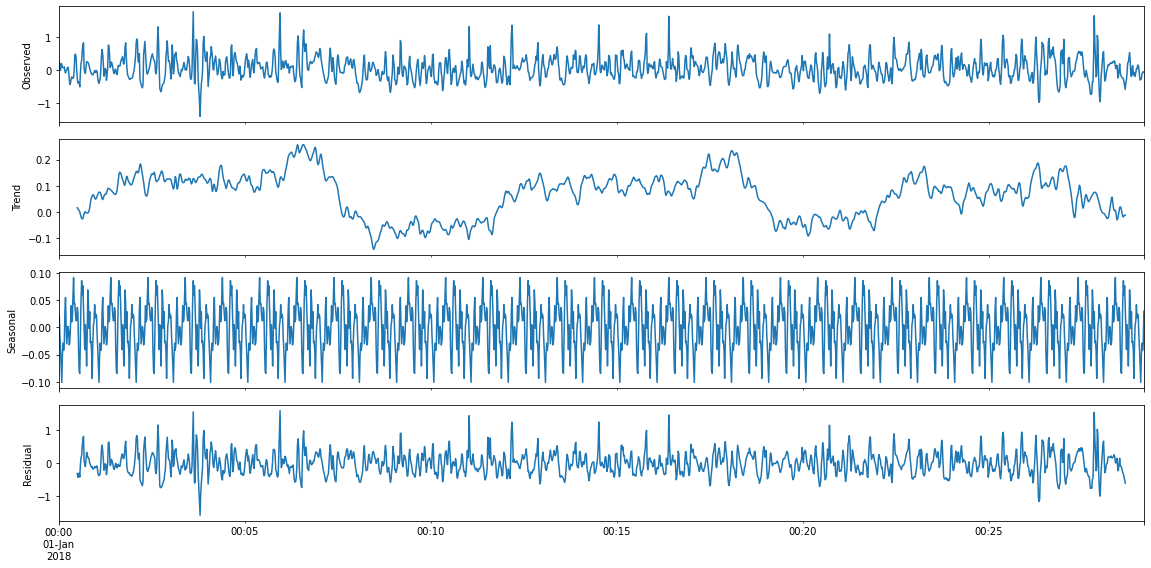

In [7]:
# Your code here:
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['figure.figsize'] = 16,8 
decompose_data = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq = 60)
decompose_data.plot()
plt.show

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

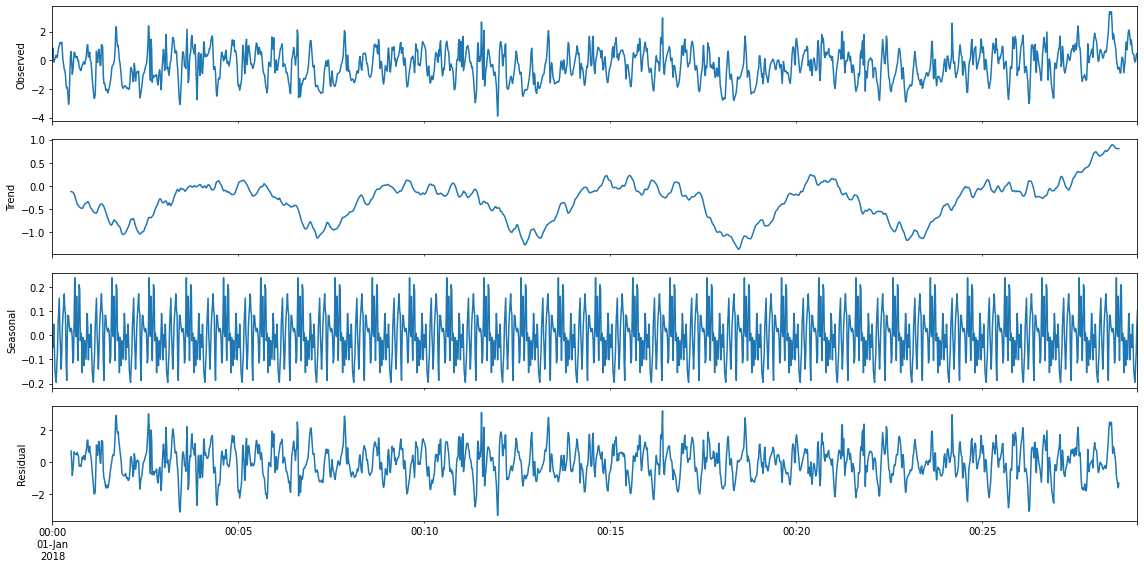

In [8]:
matplotlib.rcParams['figure.figsize'] = 16, 8
decompose_data_2 = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq = 60)
decompose_data_2.plot()
plt.show()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

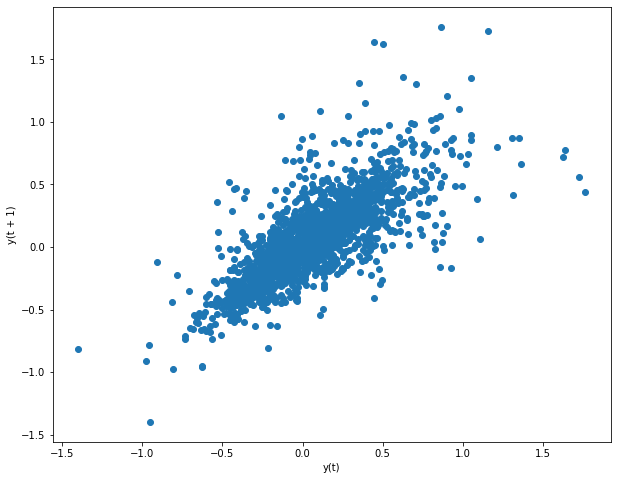

In [9]:
# Your code here:
# pandas.plotting.lag_plot(series, lag=1, ax=None, **kwds)
# laglag of the scatter plot, default 1

fig=plt.figure(figsize=(10,8))
pd.plotting.lag_plot(sensor['userAcceleration.x'], lag = 1)

Create a lag plot for `rotationRate.x`

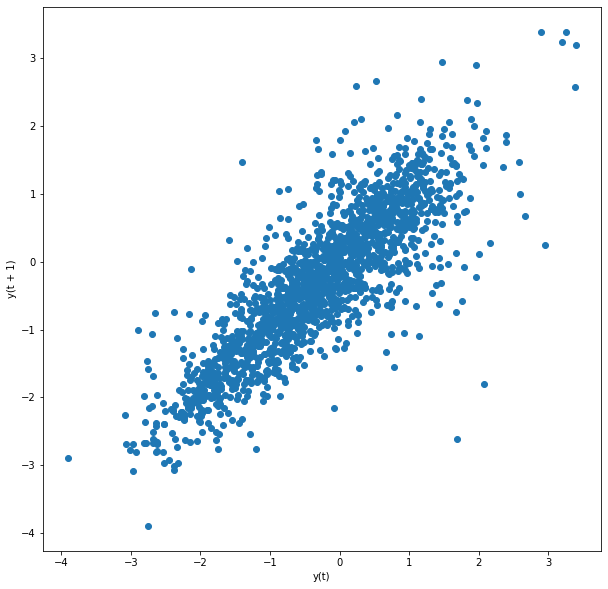

In [12]:
# Your code here:
fig = plt.figure(figsize = (10, 10))
pd.plotting.lag_plot(sensor['rotationRate.x'], lag = 1)

What are your conclusions from both visualizations?

In [ ]:
# Your conclusions here:
# Both features show a strong correlation, however it looks stronger in the 'rotationRate.x' feature. 

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [10]:
# Your code here:
from statsmodels.tsa.stattools import adfuller

acceleration_fuller = adfuller(sensor['userAcceleration.x'])
rotation_fuller = adfuller(sensor['rotationRate.x'])

print('For acceleration:')
for perc, est_need in acceleration_fuller[4].items():
  if acceleration_fuller[0]< est_need:
    print(f'It is stationary with an error probability of {perc} because {acceleration_fuller[0]} < {est_need}')

print('For rotation:')
for perc, est_need in rotation_fuller[4].items():
  if rotation_fuller[0]< est_need:
    print(f'It is stationary with an error probability of {perc} because {rotation_fuller[0]} < {est_need}')

For acceleration:
It is stationary with an error probability of 1% because -17.957994086169755 < -3.434100824760071
It is stationary with an error probability of 5% because -17.957994086169755 < -2.863196780129223
It is stationary with an error probability of 10% because -17.957994086169755 < -2.5676520210882936
For rotation:
It is stationary with an error probability of 1% because -5.269860625086422 < -3.4341465551936534
It is stationary with an error probability of 5% because -5.269860625086422 < -2.863216966926812
It is stationary with an error probability of 10% because -5.269860625086422 < -2.567662770090317


In [56]:
acceleration_fuller
rotation_fuller

(-5.269860625086422,
 6.320230335912189e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '10%': -2.567662770090317,
  '5%': -2.863216966926812},
 2619.6049719981947)

What are your conclusions from this test?

In [ ]:
# Your conclusions here:
# Both exameples have a pvalue less than 0.05 and high confidence ranges, which means both features are stationary. 


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [12]:
# Your code here:
from statsmodels.tsa.arima_model import ARMA

# statsmodels.tsa.arima_model.ARMA(endog, order, exog=None, dates=None, freq=None, missing='none') 

In [23]:
test = sensor['userAcceleration.x'][-10:]
train = sensor['userAcceleration.x'][:-10]
order = (2,1)

In [31]:
mod_ARMA = ARMA(endog = train, order = order, dates = sensor.index).fit()
prediction = mod_ARMA.predict(test.index[0],test.index[-1])

result = pd.DataFrame({'test':test,'prediction':prediction})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [28]:
# Your code here:

import statsmodels.tools.eval_measures

In [33]:
from statsmodels.tools.eval_measures import rmse

mod_rmse = rmse(result.test,result.prediction)
mod_rmse

0.22529864530183752